In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow, decompose_darcy_dataset
import matplotlib.pyplot as plt
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from copy import deepcopy
import math

In [2]:
resolution = 64

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=64,
    test_resolutions=[64]
)

Loading test db for resolution 64 with 50 samples 


/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(
/home/haltmayermarc/

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tfno_model = TFNO(
    n_modes=(16, 16), 
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    factorization='tucker',
    implementation='factorized',
    rank=0.05
)
tfno_model = tfno_model.to(device)

n_params = count_model_params(tfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 270145 parameters.


In [4]:
n_epochs = 100
optimizer = AdamW(tfno_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [5]:
"""
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'compared_TFNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)
"""

'\nimport wandb\nfrom datetime import datetime\n\nwandb.init(\n    project=\'Samsung_Project\',\n    name=f\'compared_TFNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}\'\n)\n'

In [6]:
trainer = Trainer(model=tfno_model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([50, 1, 64, 64])
[0] time=0.90, avg_loss=1.0058, train_err=50.2902
Eval: 64_h1=1.0435, 64_l2=0.5848
[1] time=0.13, avg_loss=1.0564, train_err=52.8192
Eval: 64_h1=0.9943, 64_l2=0.5701
[2] time=0.14, avg_loss=1.0073, train_err=50.3630
Eval: 64_h1=0.9838, 64_l2=0.5607
[3] time=0.12, avg_loss=0.9971, train_err=49.8541
Eval: 64_h1=0.9953, 64_l2=0.5581
[4] time=0.15, avg_loss=1.0087, train_err=50.4368
Eval: 64_h1=0.9912, 64_l2=0.5582
[5] time=0.14, avg_loss=1.0045, train_err=50.2260
Eval: 64_h1=0.9822, 64_l2=0.5598
[6] time=0.14, avg_loss=0.9954, train_err=49.7708
Eval: 64_h1=0.9801, 64_l2=0.5626
[7] time=0.14, avg_loss=0.9932, train_err=49.6589
Eval: 64_h1=0.9836, 64_l2=0.5651
[8] time=0.14, avg_loss=0.9965, train_err=49.8250
Eval: 64_h1=0.9840, 64_l2=0.5653
[9] time=0.13, avg_loss=0.9968, train_err=49.8423
Eval: 64_h1=0.9800, 64_l2=0.5633
[10] time=0.13, avg_loss=0.9928, train_err=49

{'train_err': 22.46375338123072,
 'avg_loss': 0.4492750676246144,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.14119235239923,
 '64_h1': tensor(0.4800, device='cuda:0', dtype=torch.float64),
 '64_l2': tensor(0.2353, device='cuda:0', dtype=torch.float64)}

In [7]:
#wandb.finish()

L2 error (0) : 0.3499860634591322
L2 error (1) : 0.2426843333052759
L2 error (2) : 0.2212742480459099


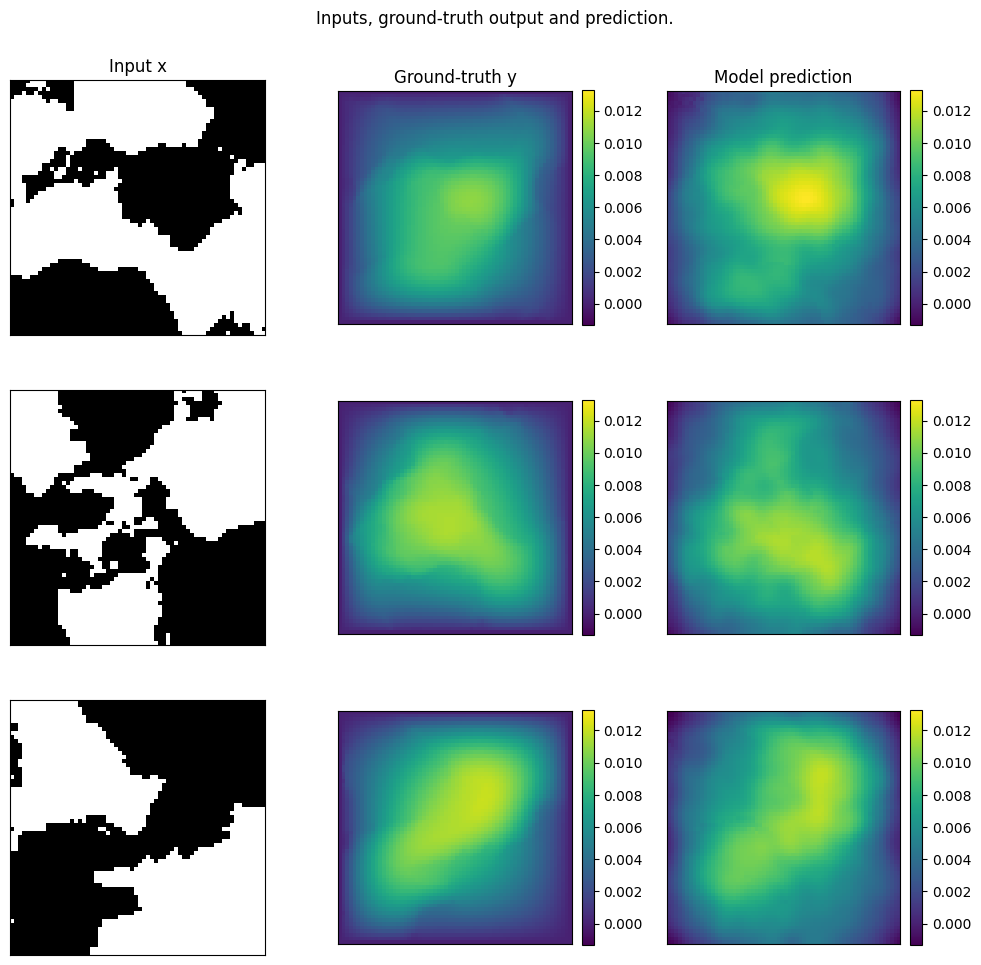

In [8]:
test_samples = test_loaders[64].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = tfno_model(x.unsqueeze(0))

    y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = tfno_model(x.unsqueeze(0)).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()

In [9]:
resolution = 64

train_loader_list, test_loaders_list, data_processor_list = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    
    decompose_dataset=True,
    subdomain_size=32,
    padding=8,
    stride=32
)

Loading test db for resolution 64 with 50 samples 


/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(
/home/haltmayermarc/

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

class CenterCropLoss(torch.nn.Module):
    def __init__(self, base_loss, crop_size: int = 32):
        super().__init__()
        self.base_loss = base_loss
        self.crop_size = crop_size

    def forward(self, pred, **sample):
        target = sample['y']
        H, W = pred.shape[-2:]
        dh = (H - self.crop_size) // 2
        dw = (W - self.crop_size) // 2
        pred_cropped = pred[:, :, dh:dh+self.crop_size, dw:dw+self.crop_size]
        return self.base_loss(pred_cropped, target)

In [11]:
"""
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'MG_TFNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)
"""

'\nimport wandb\nfrom datetime import datetime\n\nwandb.init(\n    project=\'Samsung_Project\',\n    name=f\'MG_TFNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}\'\n)\n'

In [12]:
models = []
for i in range(len(data_processor_list)):
    print("#####################################################")
    print("#### Train model No.", i)
    print("#####################################################")

    model = TFNO(
        n_modes=(16, 16),
        hidden_channels=64,
        in_channels=1,
        out_channels=1,
        factorization='tucker',
        implementation='factorized',
        rank=0.05
    ).to(device)

    n_epochs = 30
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    crop_loss = CenterCropLoss(base_loss=h1loss, crop_size=32)

    trainer = Trainer(
        model=model,
        n_epochs=n_epochs,
        device=device,
        data_processor=data_processor_list[i],
        eval_interval=10,
        verbose=True
    )

    trainer.train(
        train_loader=train_loader_list[i],
        test_loaders=test_loaders_list[i],
        optimizer=optimizer,
        scheduler=scheduler,
        training_loss=crop_loss,
        eval_losses={'h1': crop_loss}
    )

    models.append(model)

#####################################################
#### Train model No. 0
#####################################################
Training on 50 samples
Testing on [50] samples         on resolutions [64].


Raw outputs of shape torch.Size([50, 1, 48, 48])
[0] time=0.16, avg_loss=1.0052, train_err=50.2602
Eval: 64_h1=1.0298
[10] time=0.12, avg_loss=0.4397, train_err=21.9843
Eval: 64_h1=0.3729
[20] time=0.12, avg_loss=0.1802, train_err=9.0093
Eval: 64_h1=0.1731
#####################################################
#### Train model No. 1
#####################################################
Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([50, 1, 48, 48])
[0] time=0.12, avg_loss=1.0453, train_err=52.2652
Eval: 64_h1=1.6684
[10] time=0.12, avg_loss=0.4693, train_err=23.4647
Eval: 64_h1=0.4194
[20] time=0.13, avg_loss=0.2271, train_err=11.3530
Eval: 64_h1=0.2119
#####################################################
#### Train model No. 2
#####################################################
Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([50, 1, 48, 48])
[0] time=0.11, avg_los

In [13]:
def reconstruct_field(models, test_loaders_list, data_processor_list, device, global_res, local_res, stride, padding=0):
    
    full_output = torch.zeros(1, 1, global_res, global_res).to(device)
    count_map = torch.zeros_like(full_output)  # keep track of how many times each pixel is predicted

    # Compute number of subdomains per axis
    num_x = math.floor((global_res - local_res) / stride) + 1
    num_y = math.floor((global_res - local_res) / stride) + 1

    for idx, model in enumerate(models):
        i = idx // num_y
        j = idx % num_y

        model = model.to(device)
        with torch.no_grad():
            y_pred = model(test_loaders_list[idx][resolution].dataset.x[:1].to(device))
            y_pred = data_processor_list[idx].out_normalizer.inverse_transform(y_pred)

        _, _, H, W = y_pred.shape
        dh = (H - local_res) // 2
        dw = (W - local_res) // 2
        y_crop = y_pred[:, :, dh:dh + local_res, dw:dw + local_res]

        start_i = i * stride
        start_j = j * stride

        full_output[:, :, start_i:start_i + local_res, start_j:start_j + local_res] += y_crop
        count_map[:, :, start_i:start_i + local_res, start_j:start_j + local_res] += 1

    # Avoid division by zero
    count_map[count_map == 0] = 1
    full_output = full_output / count_map

    return full_output


def plot_comparison(y_full, y_reconstructed, y_tfno):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    im0 = axs[0].imshow(y_full.squeeze().cpu(), cmap='viridis')
    axs[0].set_title("Original Solution")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(y_tfno.squeeze().cpu(), cmap='viridis')
    axs[1].set_title("Full TFNO Prediction")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(y_reconstructed.squeeze().cpu(), cmap='viridis')
    axs[2].set_title("Reconstructed from Subdomains")
    fig.colorbar(im2, ax=axs[2])

    im3 = axs[3].imshow((y_reconstructed - y_tfno).abs().squeeze().cpu(), cmap='inferno')
    axs[3].set_title("Reconstruction Error")
    fig.colorbar(im3, ax=axs[3])

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


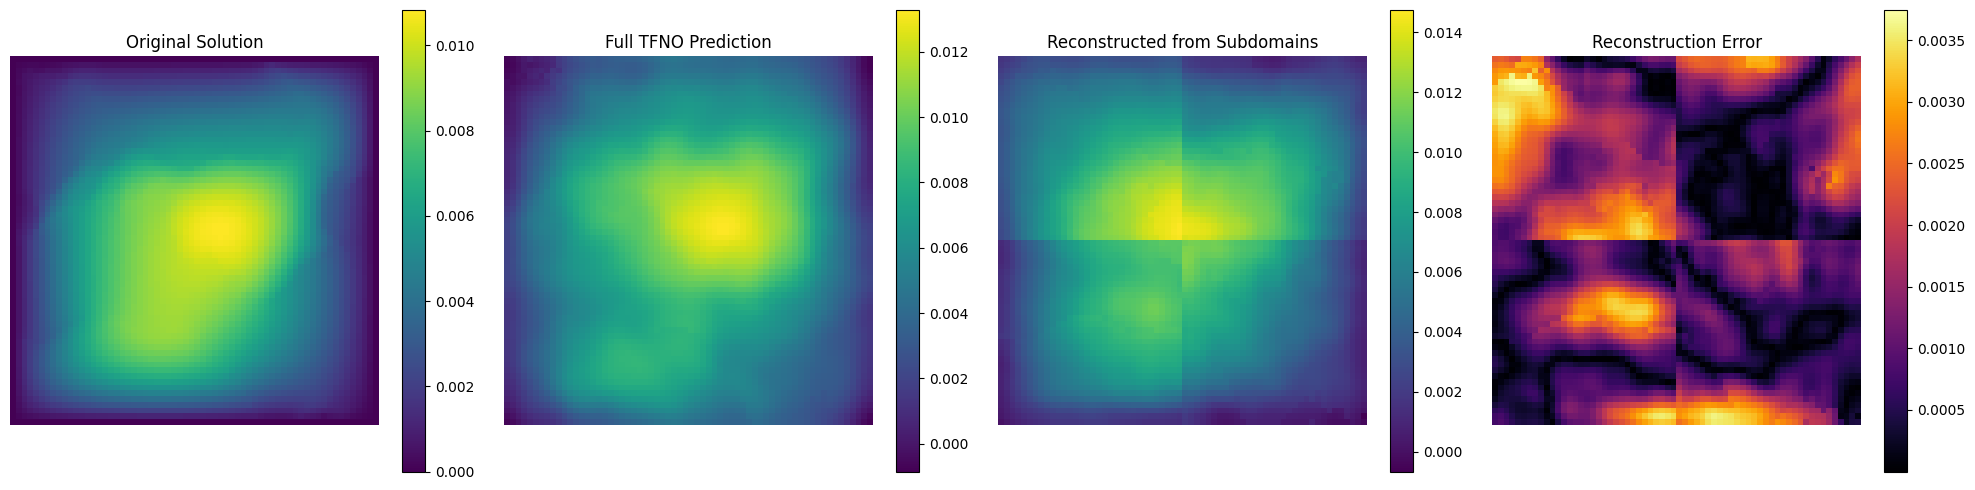

L2 error (TFNO) : 0.3499860634591322
L2 error (MG-TFNO) : 0.42815701805378886


In [14]:
with torch.no_grad():
    y_tfno = tfno_model(test_loaders[resolution].dataset.x[:1].to(device))
    y_tfno = data_processor.out_normalizer.inverse_transform(y_tfno)

# Reconstruct output from subdomains
y_reconstructed = reconstruct_field(models, test_loaders_list, data_processor_list, device, global_res=64, local_res=32, stride=32, padding=8)

# Get ground truth solution
y_full = test_loaders[resolution].dataset.y[:1].to(device)

# Plot original, TFNO, subdomain reconstruction
plot_comparison(y_full, y_reconstructed, y_tfno)

print(f'L2 error (TFNO) : {torch.norm(y_full - y_tfno) / torch.norm(y_full)}')
print(f'L2 error (MG-TFNO) : {torch.norm(y_full - y_reconstructed) / torch.norm(y_full)}')

In [15]:
y_reconstructed.shape

torch.Size([1, 1, 64, 64])

In [ ]:
resolution = 64

train_loader_list, test_loaders_list, data_processor_list = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    
    decompose_dataset=True,
    subdomain_size=32,
    padding=8,
    stride=16
)

Loading test db for resolution 64 with 50 samples 


In [ ]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'MG_TFNO_2_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

In [ ]:
models = []
for i in range(len(data_processor_list)):
    print("#####################################################")
    print("#### Train model No.", i)
    print("#####################################################")

    model = TFNO(
        n_modes=(16, 16),
        hidden_channels=64,
        in_channels=1,
        out_channels=1,
        factorization='tucker',
        implementation='factorized',
        rank=0.05
    ).to(device)

    n_epochs = 30
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    crop_loss = CenterCropLoss(base_loss=h1loss, crop_size=32)

    trainer = Trainer(
        model=model,
        n_epochs=n_epochs,
        device=device,
        data_processor=data_processor_list[i],
        eval_interval=10,
        verbose=True
    )

    trainer.train(
        train_loader=train_loader_list[i],
        test_loaders=test_loaders_list[i],
        optimizer=optimizer,
        scheduler=scheduler,
        training_loss=crop_loss,
        eval_losses={'h1': crop_loss}
    )

    models.append(model)

#####################################################
#### Train model No. 0
#####################################################
Training on 1000 samples
Testing on [50] samples         on resolutions [64].


Raw outputs of shape torch.Size([100, 1, 48, 48])
[0] time=0.43, avg_loss=0.8752, train_err=87.5196
Eval: 64_h1=0.5332
[10] time=0.47, avg_loss=0.0787, train_err=7.8673
Eval: 64_h1=0.0821
[20] time=0.42, avg_loss=0.0604, train_err=6.0382
Eval: 64_h1=0.0649
#####################################################
#### Train model No. 1
#####################################################
Training on 1000 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([100, 1, 48, 48])
[0] time=0.42, avg_loss=0.8272, train_err=82.7237
Eval: 64_h1=0.4603
[10] time=0.43, avg_loss=0.0924, train_err=9.2395
Eval: 64_h1=0.0874
[20] time=0.49, avg_loss=0.0711, train_err=7.1078
Eval: 64_h1=0.0756
#####################################################
#### Train model No. 2
#####################################################
Training on 1000 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([100, 1, 48, 48])
[0] time=0.46, avg

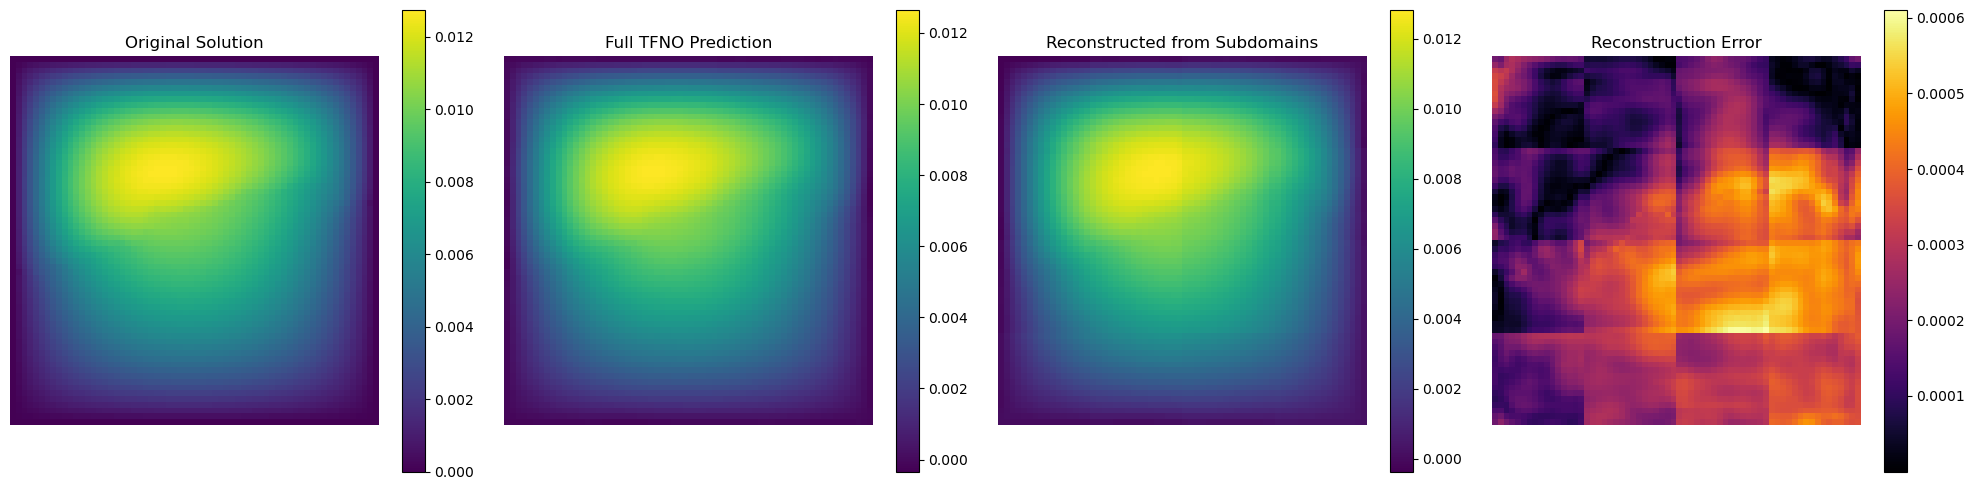

L2 error (TFNO) : 0.02087183143958925
L2 error (MG-TFNO) : 0.031898355426441496


In [ ]:
with torch.no_grad():
    y_tfno = tfno_model(test_loaders[resolution].dataset.x[:1].to(device))
    y_tfno = data_processor.out_normalizer.inverse_transform(y_tfno)

# Reconstruct output from subdomains
y_reconstructed = reconstruct_field(models, test_loaders_list, data_processor_list, device, global_res=64, local_res=32, stride=16, padding=8)

# Get ground truth solution
y_full = test_loaders[resolution].dataset.y[:1].to(device)

# Plot original, TFNO, subdomain reconstruction
plot_comparison(y_full, y_reconstructed, y_tfno)

print(f'L2 error (TFNO) : {torch.norm(y_full - y_tfno) / torch.norm(y_full)}')
print(f'L2 error (MG-TFNO) : {torch.norm(y_full - y_reconstructed) / torch.norm(y_full)}')